In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import pylab as pl
from datetime import timedelta
from datetime import datetime
from __future__ import division
import random
from scipy import optimize
import time
import seaborn as sns
import csv
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, OrthogonalMatchingPursuit
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing, svm, metrics, tree, decomposition, svm
from sklearn.model_selection import ParameterGrid
import warnings
import itertools
from sklearn.model_selection import train_test_split

## Read Data

In [9]:
working_dir = "/Users/pedrogalarza/Documents/NYU-MSDS/2022_spring/RDS_indepedent-study/diggs/models"
data_dir = "/Users/pedrogalarza/Documents/NYU-MSDS/2022_spring/RDS_indepedent-study/data/final_model_data"


results_metrics_data_path = os.path.join(data_dir, 'medium_grid2-100_result-metrics_2022-05-01_did_processed_data_2021.csv')
train_set_data_path = os.path.join(data_dir, 'medium_grid2-100_train-set_2022-05-01_did_processed_data_2021.csv')
test_set_data_path = os.path.join(data_dir, 'medium_grid2-100_test-set_2022-05-01_did_processed_data_2021.csv')
full_set_path = os.path.join(data_dir, 'medium_grid2-100_full-set_2022-05-01_did_processed_data_2021.csv')
orig_set_path = os.path.join(data_dir, '2022-05-01_did_processed_data_2021.csv')

# test_data_df = pd.read_csv(test_data_path)
metrics_df = pd.read_csv(results_metrics_data_path)
train_df = pd.read_csv(train_set_data_path)
test_df = pd.read_csv(test_set_data_path)
full_df = pd.read_csv(full_set_path)
orig_df = pd.read_csv(orig_set_path)

##Label Distribution

In [3]:
test_df.std_decision.value_counts()

deny            130
matriculated     13
Name: std_decision, dtype: int64

In [4]:
train_df.std_decision.value_counts()

deny            521
matriculated     50
Name: std_decision, dtype: int64

In [5]:
full_df.std_decision.value_counts()

deny            651
matriculated     63
Name: std_decision, dtype: int64

In [6]:
orig_df.std_decision.value_counts()

deny                        651
no_decision                 562
matriculated                 63
withdrawn                    53
withdrawn_after_decision      1
Name: std_decision, dtype: int64

## Results Formatting

In [10]:
metrics_df['unique_model_str'] = metrics_df.clf + '_' + metrics_df.param + "_" + metrics_df.demo_features.astype(str) + \
                                                                       "_" + metrics_df.academic_features.astype(str) + \
                                                                       "_" + metrics_df.application_features.astype(str) + \
                                                                       "_" + metrics_df.school_features.astype(str)

In [11]:
metrics_df

,clf,param,demo_features,academic_features,application_features,school_features,xv_split,topk_precision,topk_recall,random_topk_precision,precision,recall,auc,model,unique_model_str
0,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",1,0,0,0,0,0.3,0.3,0.086957,0.000000,0.0,0.550476,"RandomForestClassifier(max_depth=100, max_feat...","RF_{'max_depth': 5, 'max_features': 'sqrt', 'm..."
1,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",1,0,0,0,1,0.2,0.2,0.087719,0.000000,0.0,0.638942,"RandomForestClassifier(max_depth=100, max_feat...","RF_{'max_depth': 5, 'max_features': 'sqrt', 'm..."
2,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",1,0,0,0,2,0.1,0.1,0.087719,0.000000,0.0,0.441346,"RandomForestClassifier(max_depth=100, max_feat...","RF_{'max_depth': 5, 'max_features': 'sqrt', 'm..."
3,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",1,0,0,0,3,0.2,0.2,0.087719,0.000000,0.0,0.604808,"RandomForestClassifier(max_depth=100, max_feat...","RF_{'max_depth': 5, 'max_features': 'sqrt', 'm..."
4,RF,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",1,0,0,0,4,0.3,0.3,0.087719,0.000000,0.0,0.592308,"RandomForestClassifier(max_depth=100, max_feat...","RF_{'max_depth': 5, 'max_features': 'sqrt', 'm..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36745,DT,"{'criterion': 'entropy', 'max_depth': 100, 'ma...",1,1,1,1,20,0.0,0.0,0.086957,0.000000,0.0,0.517619,"DecisionTreeClassifier(criterion='entropy', ma...","DT_{'criterion': 'entropy', 'max_depth': 100, ..."
36746,DT,"{'criterion': 'entropy', 'max_depth': 100, 'ma...",1,1,1,1,21,0.0,0.0,0.087719,0.000000,0.0,0.445192,"DecisionTreeClassifier(criterion='entropy', ma...","DT_{'criterion': 'entropy', 'max_depth': 100, ..."
36747,DT,"{'criterion': 'entropy', 'max_depth': 100, 'ma...",1,1,1,1,22,0.1,0.1,0.087719,0.076923,0.1,0.606731,"DecisionTreeClassifier(criterion='entropy', ma...","DT_{'criterion': 'entropy', 'max_depth': 100, ..."
36748,DT,"{'criterion': 'entropy', 'max_depth': 100, 'ma...",1,1,1,1,23,0.2,0.2,0.087719,0.200000,0.1,0.666346,"DecisionTreeClassifier(criterion='entropy', ma...","DT_{'criterion': 'entropy', 'max_depth': 100, ..."


## Top Scoring Models - All

In [14]:
summary_metrics_df = metrics_df.groupby(['clf',
                                         'param',
                                         'demo_features',
                                         'academic_features',
                                         'application_features',
                                         'school_features']).agg({'topk_precision':['mean','std'],
                                                                  'random_topk_precision':['mean','std'],
                                                                  'topk_recall':['mean','std'],                                                                  
                                                                  'precision':['mean','std'],
                                                                  'recall':['mean','std'],
                                                                  'auc':['mean','std']})#.sort_values(['topk_precision'])

summary_metrics_df = summary_metrics_df.reset_index()
summary_metrics_df.columns = [('_'.join(col).strip()).rstrip('_') for col in summary_metrics_df.columns.values]

sorted_summary_metrics_df=summary_metrics_df.sort_values('topk_precision_mean',ascending =False)
sorted_summary_metrics_df.head(10)

,clf,param,demo_features,academic_features,application_features,school_features,topk_precision_mean,topk_precision_std,random_topk_precision_mean,random_topk_precision_std,topk_recall_mean,topk_recall_std,precision_mean,precision_std,recall_mean,recall_std,auc_mean,auc_std
687,LR,"{'C': 100, 'penalty': 'l2', 'solver': 'libline...",1,1,0,1,0.248,0.100499,0.087567,0.000311,0.248,0.100499,0.237489,0.145602,0.196,0.120692,0.637450,0.058603
683,LR,"{'C': 100, 'penalty': 'l2', 'solver': 'libline...",1,0,0,1,0.244,0.108321,0.087567,0.000311,0.244,0.108321,0.242687,0.128248,0.192,0.107703,0.643580,0.061840
668,LR,"{'C': 100, 'penalty': 'l1', 'solver': 'libline...",1,0,0,1,0.240,0.100000,0.087567,0.000311,0.240,0.100000,0.241697,0.136215,0.212,0.133292,0.640511,0.062907
713,LR,"{'C': 1000, 'penalty': 'l2', 'solver': 'liblin...",1,0,0,1,0.240,0.108012,0.087567,0.000311,0.240,0.108012,0.238866,0.112329,0.220,0.125831,0.642813,0.061058
642,LR,"{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}",1,1,0,1,0.236,0.099499,0.087567,0.000311,0.236,0.099499,0.271035,0.229351,0.140,0.095743,0.640957,0.055446
698,LR,"{'C': 1000, 'penalty': 'l1', 'solver': 'liblin...",1,0,0,1,0.236,0.125433,0.087567,0.000311,0.236,0.125433,0.249585,0.149281,0.220,0.141421,0.638711,0.064887
672,LR,"{'C': 100, 'penalty': 'l1', 'solver': 'libline...",1,1,0,1,0.236,0.099499,0.087567,0.000311,0.236,0.099499,0.233015,0.119071,0.212,0.123558,0.630134,0.059667
670,LR,"{'C': 100, 'penalty': 'l1', 'solver': 'libline...",1,0,1,1,0.236,0.122066,0.087567,0.000311,0.236,0.122066,0.228884,0.141081,0.212,0.145258,0.656110,0.059951
685,LR,"{'C': 100, 'penalty': 'l2', 'solver': 'libline...",1,0,1,1,0.232,0.098826,0.087567,0.000311,0.232,0.098826,0.251789,0.129119,0.208,0.115181,0.658557,0.060020
689,LR,"{'C': 100, 'penalty': 'l2', 'solver': 'libline...",1,1,1,1,0.232,0.080208,0.087567,0.000311,0.232,0.080208,0.228017,0.132630,0.196,0.113578,0.645755,0.055596


In [10]:
sorted_summary_metrics_df.param.iloc[0]

"{'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}"

## Top Scoring Models - No School Features

In [15]:
sorted_summary_metrics_df[(sorted_summary_metrics_df.clf != None) &\
                          (sorted_summary_metrics_df.school_features!=1)]

,clf,param,demo_features,academic_features,application_features,school_features,topk_precision_mean,topk_precision_std,random_topk_precision_mean,random_topk_precision_std,topk_recall_mean,topk_recall_std,precision_mean,precision_std,recall_mean,recall_std,auc_mean,auc_std
641,LR,"{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}",1,1,0,0,0.192,0.099666,0.087567,0.000311,0.192,0.099666,0.147333,0.261126,0.040,0.064550,0.637595,0.074275
686,LR,"{'C': 100, 'penalty': 'l2', 'solver': 'libline...",1,1,0,0,0.192,0.099666,0.087567,0.000311,0.192,0.099666,0.236714,0.260690,0.076,0.077889,0.641929,0.075499
652,LR,"{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}",1,0,0,0,0.188,0.116619,0.087567,0.000311,0.188,0.116619,0.088000,0.179925,0.028,0.054160,0.641642,0.079757
787,RF,"{'max_depth': 100, 'max_features': 'log2', 'mi...",1,0,0,0,0.184,0.089815,0.087567,0.000311,0.184,0.089815,0.000000,0.000000,0.000,0.000000,0.609118,0.092011
907,RF,"{'max_depth': 100, 'max_features': 'sqrt', 'mi...",1,0,0,0,0.184,0.085049,0.087567,0.000311,0.184,0.085049,0.000000,0.000000,0.000,0.000000,0.607321,0.092764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,LR,"{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}",0,1,1,0,0.024,0.043589,0.087567,0.000311,0.024,0.043589,0.000000,0.000000,0.000,0.000000,0.451392,0.089184
588,LR,"{'C': 0.1, 'penalty': 'l2', 'solver': 'libline...",0,1,0,0,0.020,0.040825,0.087567,0.000311,0.020,0.040825,0.000000,0.000000,0.000,0.000000,0.425760,0.077230
590,LR,"{'C': 0.1, 'penalty': 'l2', 'solver': 'libline...",0,1,1,0,0.016,0.037417,0.087567,0.000311,0.016,0.037417,0.000000,0.000000,0.000,0.000000,0.421147,0.090718
618,LR,"{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}",0,1,0,0,0.012,0.033166,0.087567,0.000311,0.012,0.033166,0.000000,0.000000,0.000,0.000000,0.423433,0.087349


## Top Scoring Models - Random Forest

In [16]:
sorted_summary_metrics_df[sorted_summary_metrics_df.clf == 'RF']#.param.iloc[0]#.head()

,clf,param,demo_features,academic_features,application_features,school_features,topk_precision_mean,topk_precision_std,random_topk_precision_mean,random_topk_precision_std,topk_recall_mean,topk_recall_std,precision_mean,precision_std,recall_mean,recall_std,auc_mean,auc_std
1313,RF,"{'max_depth': 50, 'max_features': 'log2', 'min...",1,0,0,1,0.196,0.105987,0.087567,0.000311,0.196,0.105987,0.00,0.0,0.000,0.00,0.602085,0.087260
1253,RF,"{'max_depth': 50, 'max_features': 'log2', 'min...",1,0,0,1,0.192,0.128841,0.087567,0.000311,0.192,0.128841,0.00,0.0,0.000,0.00,0.621089,0.076673
773,RF,"{'max_depth': 100, 'max_features': 'log2', 'mi...",1,0,0,1,0.192,0.099666,0.087567,0.000311,0.192,0.099666,0.00,0.0,0.000,0.00,0.617657,0.074891
833,RF,"{'max_depth': 100, 'max_features': 'log2', 'mi...",1,0,0,1,0.188,0.092736,0.087567,0.000311,0.188,0.092736,0.00,0.0,0.000,0.00,0.599861,0.081800
893,RF,"{'max_depth': 100, 'max_features': 'sqrt', 'mi...",1,0,0,1,0.184,0.098658,0.087567,0.000311,0.184,0.098658,0.00,0.0,0.000,0.00,0.615181,0.087526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,RF,"{'max_depth': 50, 'max_features': 'log2', 'min...",0,1,1,1,0.044,0.058310,0.087567,0.000311,0.044,0.058310,0.00,0.0,0.000,0.00,0.501988,0.086287
1416,RF,"{'max_depth': 50, 'max_features': 'sqrt', 'min...",0,1,1,1,0.044,0.065064,0.087567,0.000311,0.044,0.065064,0.00,0.0,0.000,0.00,0.478937,0.072255
980,RF,"{'max_depth': 100, 'max_features': 'sqrt', 'mi...",0,1,1,0,0.044,0.065064,0.087567,0.000311,0.044,0.065064,0.00,0.0,0.000,0.00,0.480737,0.069001
1250,RF,"{'max_depth': 50, 'max_features': 'log2', 'min...",0,1,1,0,0.040,0.057735,0.087567,0.000311,0.040,0.057735,0.04,0.2,0.004,0.02,0.496129,0.071224


## Top Scoring Models - Decision Tree

In [17]:
sorted_summary_metrics_df[sorted_summary_metrics_df.clf == 'DT'].head()

,clf,param,demo_features,academic_features,application_features,school_features,topk_precision_mean,topk_precision_std,random_topk_precision_mean,random_topk_precision_std,topk_recall_mean,topk_recall_std,precision_mean,precision_std,recall_mean,recall_std,auc_mean,auc_std
337,DT,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",1,0,0,0,0.164,0.090738,0.087567,0.000311,0.164,0.090738,0.152563,0.125067,0.108,0.095394,0.555896,0.067492
157,DT,"{'criterion': 'entropy', 'max_depth': 20, 'max...",1,0,0,0,0.152,0.082260,0.087567,0.000311,0.152,0.082260,0.139043,0.110904,0.128,0.106145,0.531769,0.064322
112,DT,"{'criterion': 'entropy', 'max_depth': 100, 'ma...",1,0,0,0,0.148,0.087178,0.087567,0.000311,0.148,0.087178,0.140358,0.097628,0.132,0.102956,0.530871,0.062410
503,DT,"{'criterion': 'gini', 'max_depth': 50, 'max_fe...",1,0,0,1,0.148,0.104563,0.087567,0.000311,0.148,0.104563,0.177206,0.162578,0.104,0.105987,0.521937,0.062481
427,DT,"{'criterion': 'gini', 'max_depth': 20, 'max_fe...",1,0,0,0,0.148,0.091833,0.087567,0.000311,0.148,0.091833,0.151500,0.103617,0.128,0.102144,0.542720,0.062058


## Train Top Models

## get features/ labels

In [18]:
#define feature_set
demo_features = [] #Race, cultureal_id, sex, hispanic, #income, parent income
academic_features = [] #gpas, non-nyu-stem,
application_features = [] # stubmitted dates, started dates, missing itmes
school_features = [] #schools

for col in train_df.columns:
    #demo features
    if col.startswith('oh_race'):
        demo_features.append(col)     
    elif col.startswith('oh_cultural_id'):
        demo_features.append(col)
    elif col.startswith('oh_sex'):
        demo_features.append(col)
    elif col.startswith('oh_hispanic'):
        demo_features.append(col)
    elif col.startswith('oh_income'):
        demo_features.append(col)
    elif col.startswith('oh_parent'):
    #academic feature
        demo_features.append(col)
    elif col.startswith('oh_gpa'):
        academic_features.append(col)
    elif col.startswith('std_imputed_gpa'):
        academic_features.append(col)        
    elif col.startswith('oh_non'):
        academic_features.append(col)
    #application features        
    elif col.startswith('oh_missing'):
        application_features.append(col)  
    elif col.startswith('std_imputed_app'):
        application_features.append(col)        
#     school features
    elif col.startswith('oh_school_'):
        school_features.append(col) 

feature_set_dict = {
                    'demo_features': demo_features,
                    'academic_features': academic_features,
                    'application_features': application_features,
                    'school_features': school_features,
                    }

In [19]:
academic_features

['oh_gpa_nan',
 'std_imputed_gpa',
 'std_imputed_gpa_specified',
 'oh_non_nyu_stem']

In [21]:
def feature_set_filter(df, feature_set_str = '0100',feature_set_dict = feature_set_dict):
    features = []
    for index, indicator in enumerate(feature_set_str):
        if indicator == '1':
            features.append(feature_set_dict[list(feature_set_dict.keys())[index]])         
    features=[item for sublist in features for item in sublist]
    return df[features]

def topk_predict(y_proba, k):
    #predict based on topk threshold
    y_topk_preds = y_proba.copy()
    top_proba = list(y_proba.argsort()[-k:][::-1])
    bot_proba = list(y_proba.argsort()[:-k])
    y_topk_preds[top_proba] =1.
    y_topk_preds[bot_proba] =0.
    return y_topk_preds

In [22]:
train_df.std_decision.value_counts()

deny            521
matriculated     50
Name: std_decision, dtype: int64

In [23]:
test_df.std_decision.value_counts()

deny            130
matriculated     13
Name: std_decision, dtype: int64

In [24]:
y_train = np.array(((train_df.std_decision  == 'deny')*-1 + 1))
X_train = np.array(feature_set_filter(train_df, feature_set_str = '1101'))
filtered_columns = np.array(feature_set_filter(train_df, feature_set_str = '1101').columns)

y_test = np.array(((test_df.std_decision  == 'deny')*-1 + 1))
X_test = np.array(feature_set_filter(test_df, feature_set_str = '1101'))

p =  {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}

clf = LogisticRegression()
clf.set_params(**p)
clf.fit(X_train,y_train)

y_proba = clf.predict_proba(X_test)[:,1]
y_preds = clf.predict(X_test)

y_topk_preds = topk_predict(y_proba, k = y_test.sum())

precision_score(y_test,y_topk_preds),y_test.sum()/len(y_test)

(0.38461538461538464, 0.09090909090909091)

(array([109.,  12.,   5.,   4.,   3.,   3.,   2.,   1.,   3.,   1.]),
 array([3.14683035e-07, 9.99768617e-02, 1.99953409e-01, 2.99929956e-01,
        3.99906503e-01, 4.99883050e-01, 5.99859597e-01, 6.99836144e-01,
        7.99812691e-01, 8.99789238e-01, 9.99765785e-01]),
 <BarContainer object of 10 artists>)

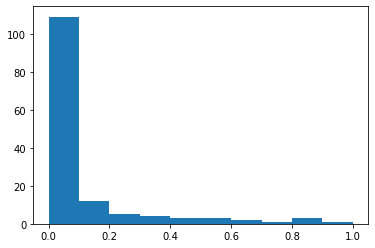

In [25]:
plt.hist(y_proba)

In [57]:
demo_corr_df

,oh_cultural_id_nan,oh_cultural_id_hawiian_origin,oh_cultural_id_european_origin,oh_cultural_id_african_origin,oh_cultural_id_mexican_origin,oh_cultural_id_south_american_origin,oh_cultural_id_middle_eastern_origin,oh_cultural_id_east_asian_origin,oh_cultural_id_puerto_rican_origin,oh_cultural_id_north_african_origin,...,oh_income_nan,oh_parent_education_none,oh_parent_education_one,oh_parent_education_two_or_more,oh_parent_education_nan,oh_gpa_nan,std_imputed_gpa,std_imputed_gpa_specified,oh_non_nyu_stem,oh_decision
oh_cultural_id_nan,1.000000,-0.012398,-0.124646,-0.077917,-0.043369,-0.067217,-0.068470,-0.171098,-0.037459,-0.043369,...,NaN,-0.064248,-0.010223,0.081105,NaN,0.091217,0.021702,0.008824,0.051330,-0.046169
oh_cultural_id_hawiian_origin,-0.012398,1.000000,-0.017638,0.159123,-0.006137,-0.009511,-0.009689,0.072463,-0.005300,-0.006137,...,NaN,0.038433,-0.020114,-0.025454,NaN,-0.006137,0.015612,0.018359,0.045648,-0.012976
oh_cultural_id_european_origin,-0.124646,-0.017638,1.000000,-0.090953,0.006576,-0.050273,0.058700,-0.152992,-0.013976,-0.061697,...,NaN,-0.232852,0.048741,0.218512,NaN,-0.027560,0.083902,0.079324,0.046099,-0.026515
oh_cultural_id_african_origin,-0.077917,0.159123,-0.090953,1.000000,-0.038567,0.006116,-0.060888,-0.135731,-0.033311,0.011032,...,NaN,-0.029813,0.037676,0.000337,NaN,-0.038567,0.024371,-0.090443,0.015532,-0.006039
oh_cultural_id_mexican_origin,-0.043369,-0.006137,0.006576,-0.038567,1.000000,-0.033271,0.021717,-0.084690,0.079487,-0.021467,...,NaN,0.085419,-0.070359,-0.034016,NaN,0.063655,0.004133,-0.051323,0.086149,0.084197
oh_cultural_id_south_american_origin,-0.067217,-0.009511,-0.050273,0.006116,-0.033271,1.000000,-0.052526,-0.112539,0.101490,-0.033271,...,NaN,0.061841,-0.025915,-0.046629,NaN,-0.033271,-0.091296,-0.027100,-0.029281,0.044419
oh_cultural_id_middle_eastern_origin,-0.068470,-0.009689,0.058700,-0.060888,0.021717,-0.052526,1.000000,-0.096885,-0.029272,0.466585,...,NaN,-0.043941,-0.008878,0.057128,NaN,-0.033891,0.055900,0.049630,0.011918,0.069434
oh_cultural_id_east_asian_origin,-0.171098,0.072463,-0.152992,-0.135731,-0.084690,-0.112539,-0.096885,1.000000,-0.073147,-0.084690,...,NaN,0.043527,0.033180,-0.078031,NaN,-0.028329,-0.007932,0.133687,-0.002956,0.021137
oh_cultural_id_puerto_rican_origin,-0.037459,-0.005300,-0.013976,-0.033311,0.079487,0.101490,-0.029272,-0.073147,1.000000,-0.018541,...,NaN,0.031439,-0.024737,-0.013539,NaN,-0.018541,0.041719,0.030757,0.025013,-0.039203
oh_cultural_id_north_african_origin,-0.043369,-0.006137,-0.061697,0.011032,-0.021467,-0.033271,0.466585,-0.084690,-0.018541,1.000000,...,NaN,0.011890,-0.007781,-0.006504,NaN,-0.021467,0.031712,0.039462,0.037129,-0.002194


<ipython-input-146-9deae5ef7586>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_corr_df['oh_decision'] = y_train


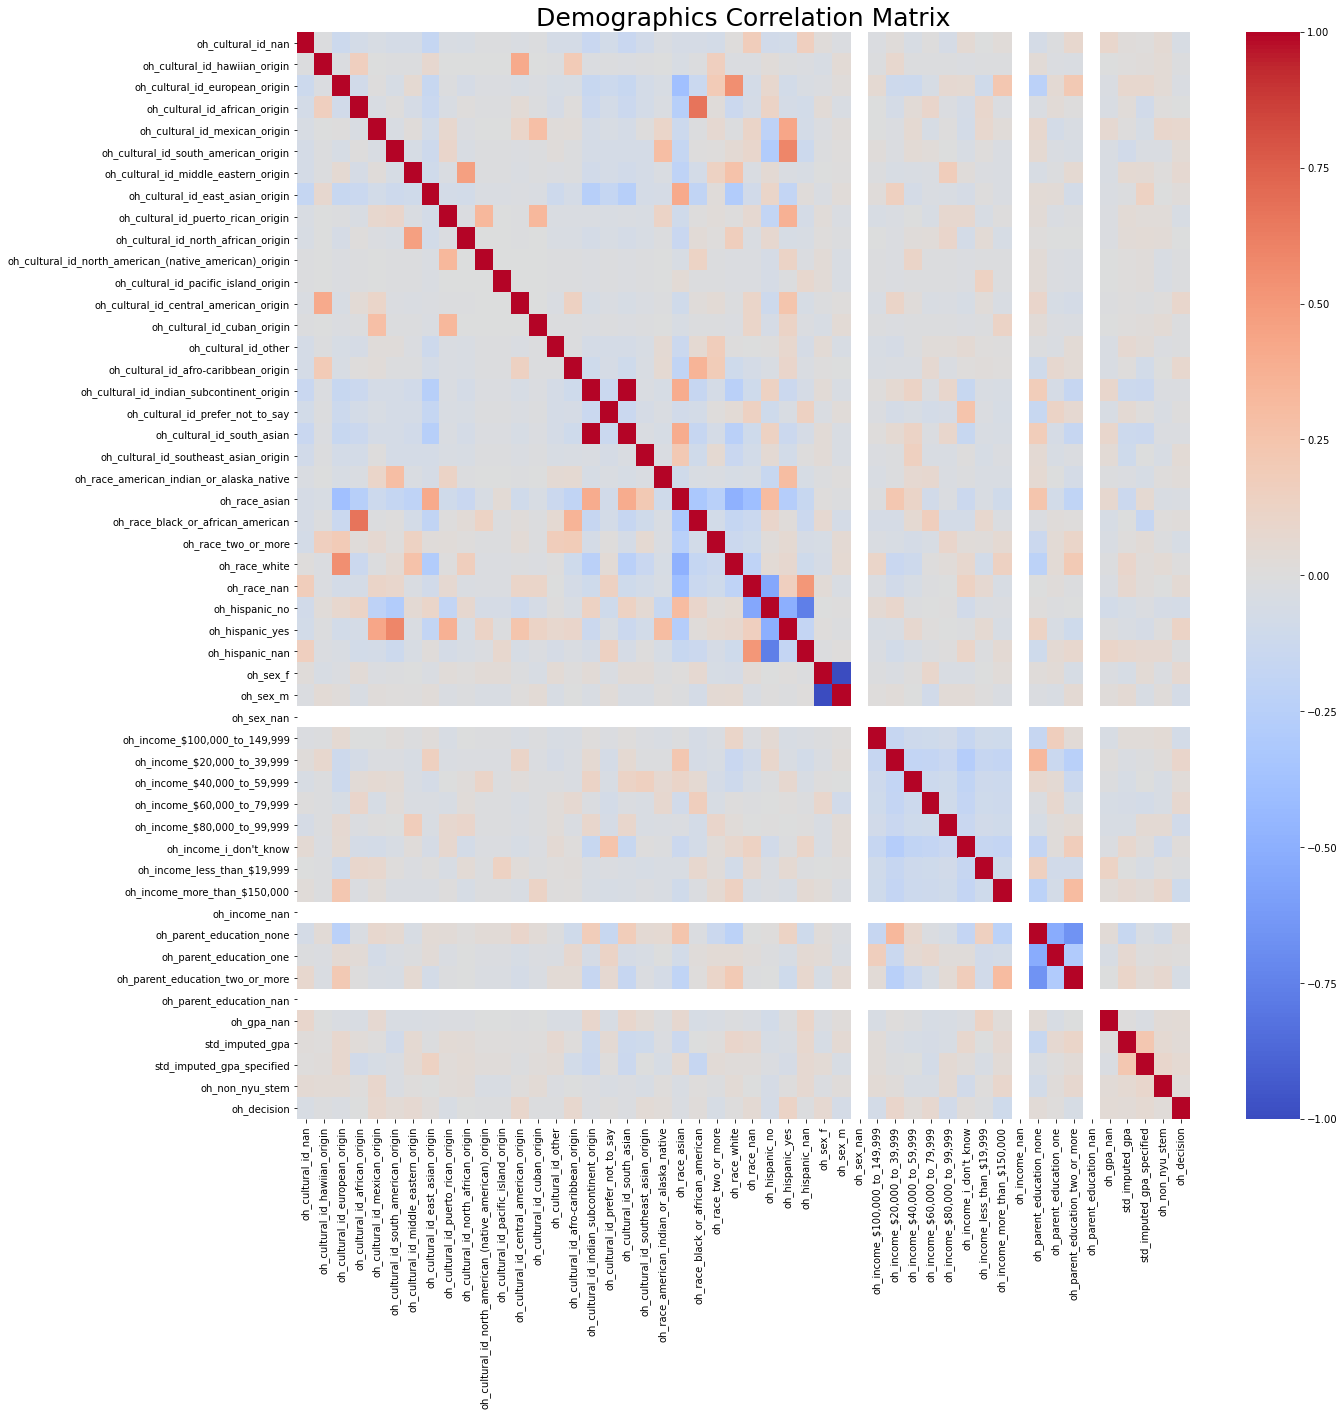

In [146]:
demo_corr_df = feature_set_filter(train_df, feature_set_str = '1100')
demo_corr_df['oh_decision'] = y_train

# corr_df.corr(columns = list(corr_df.columns))
demo_corr_df = demo_corr_df.corr()
# demo_corr_df = demo_corr_df**2
fig, ax = plt.subplots(1,1,figsize=(20,20))
sns.heatmap(demo_corr_df, cmap="coolwarm",ax = ax)
plt.title('Demographics Correlation Matrix',fontsize = 25)
plt.show()


In [133]:
full_corr_df = feature_set_filter(train_df, feature_set_str = '1111')
full_corr_df['oh_decision'] = y_train


full_corr_df = full_corr_df.corr()
full_corr_col = full_corr_df.columns
full_corr_df = full_corr_df.reset_index()
full_corr_df_melt = pd.melt(full_corr_df,id_vars=['index'])


full_corr_df_melt = full_corr_df_melt[full_corr_df_melt['value'] != 1]#full_corr_df_melt['variable']]
full_corr_df_melt = full_corr_df_melt[full_corr_df_melt['value'] != -1]#full_corr_df_melt['variable']]

full_corr_df_melt =full_corr_df_melt.dropna()
full_corr_df_melt['value_abs'] = np.abs(full_corr_df_melt['value'])
full_corr_df_melt['cor'] = full_corr_df_melt['index'] + '_' + full_corr_df_melt['variable']
full_corr_df_melt['cor_flip'] = full_corr_df_melt['variable'] + '_' + full_corr_df_melt['index']
full_corr_df_melt = full_corr_df_melt[full_corr_df_melt['cor'] != full_corr_df_melt['cor_flip']]#full_corr_df_melt['variable']]
full_corr_df_melt = full_corr_df_melt.sort_values(by='value_abs',ascending=False)

full_corr_df_melt =  full_corr_df_melt[:100]
full_corr_df_melt

<ipython-input-133-dad1109ebca0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_corr_df['oh_decision'] = y_train


,index,variable,value,value_abs,cor,cor_flip
7222,oh_hispanic_no,oh_hispanic_nan,-0.764255,0.764255,oh_hispanic_no_oh_hispanic_nan,oh_hispanic_nan_oh_hispanic_no
6710,oh_hispanic_nan,oh_hispanic_no,-0.764255,0.764255,oh_hispanic_nan_oh_hispanic_no,oh_hispanic_no_oh_hispanic_nan
793,oh_race_black_or_african_american,oh_cultural_id_african_origin,0.671787,0.671787,oh_race_black_or_african_american_oh_cultural_...,oh_cultural_id_african_origin_oh_race_black_or...
5657,oh_cultural_id_african_origin,oh_race_black_or_african_american,0.671787,0.671787,oh_cultural_id_african_origin_oh_race_black_or...,oh_race_black_or_african_american_oh_cultural_...
11092,oh_parent_education_none,oh_parent_education_two_or_more,-0.662297,0.662297,oh_parent_education_none_oh_parent_education_t...,oh_parent_education_two_or_more_oh_parent_educ...
...,...,...,...,...,...,...
2369,oh_school_acad_conservation_and_environ,oh_cultural_id_north_african_origin,0.285876,0.285876,oh_school_acad_conservation_and_environ_oh_cul...,oh_cultural_id_north_african_origin_oh_school_...
61170,oh_cultural_id_mexican_origin,oh_school_uncommon_charter_high_school,0.285876,0.285876,oh_cultural_id_mexican_origin_oh_school_uncomm...,oh_school_uncommon_charter_high_school_oh_cult...
1266,oh_school_uncommon_charter_high_school,oh_cultural_id_mexican_origin,0.285876,0.285876,oh_school_uncommon_charter_high_school_oh_cult...,oh_cultural_id_mexican_origin_oh_school_uncomm...
1247,oh_school_saint_joseph_by_the_sea_hs,oh_cultural_id_mexican_origin,0.285876,0.285876,oh_school_saint_joseph_by_the_sea_hs_oh_cultur...,oh_cultural_id_mexican_origin_oh_school_saint_...


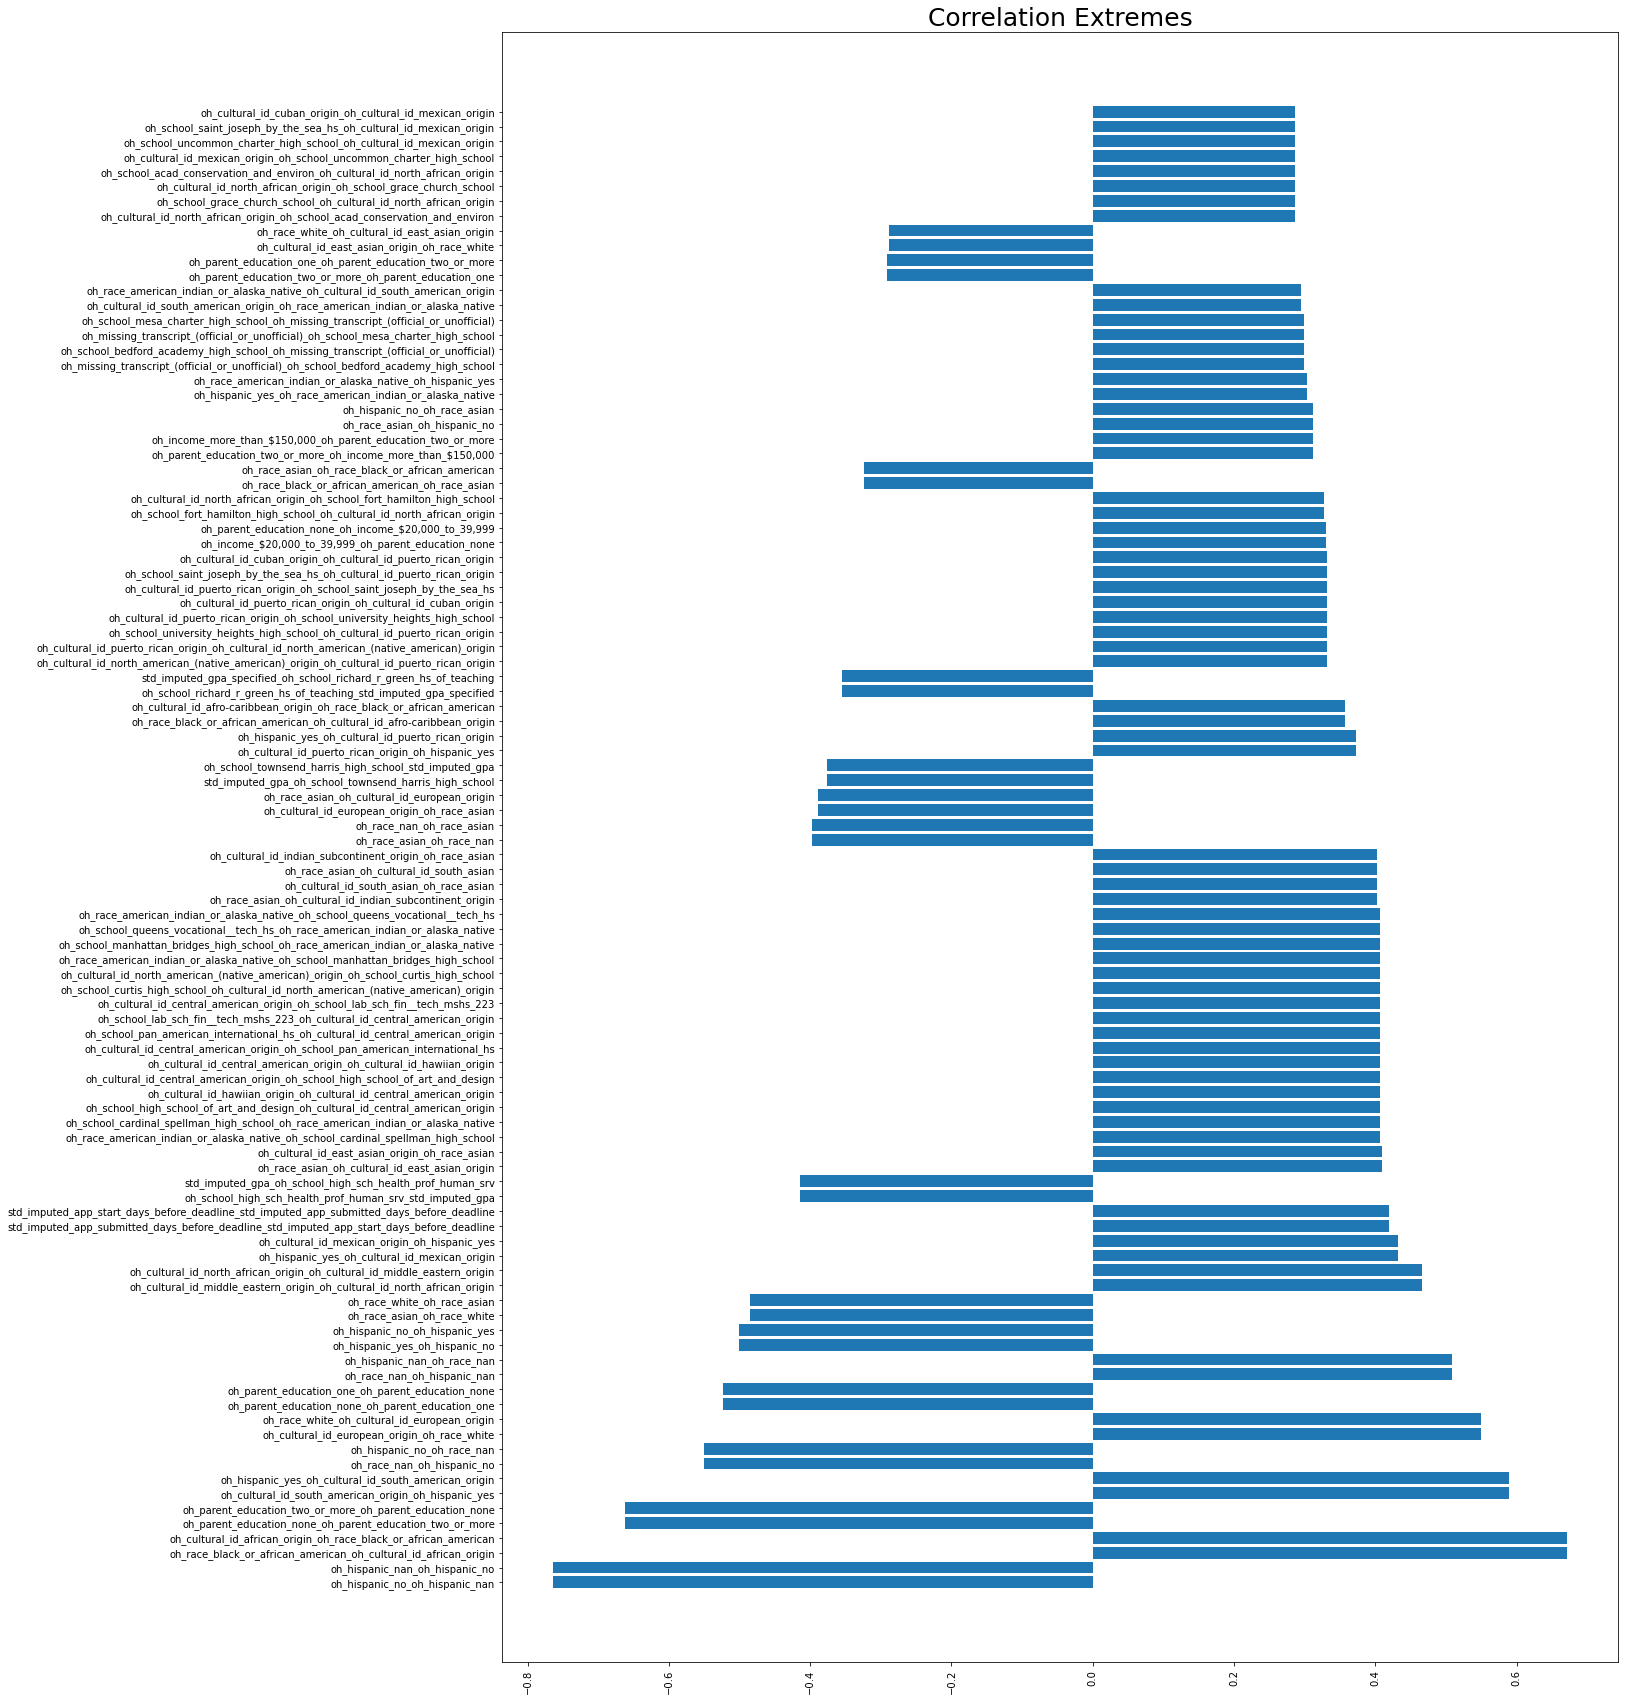

In [138]:
fig,ax = plt.subplots(1,figsize = (20,30))

ax.barh(full_corr_df_melt.cor,full_corr_df_melt.value)
plt.xticks(rotation = 90)
plt.title('Correlation Extremes',fontsize = 25)
plt.show()

In [139]:
coefs = np.vstack((filtered_columns,clf.coef_[0])).T
coefs_df = pd.DataFrame(coefs,columns = ['column_names','coef_value'])
coefs_df_filtered = coefs_df[coefs_df.coef_value !=0].sort_values('coef_value', ascending = False)
coefs_df_filtered['coef_value_abs'] = coefs_df_filtered.coef_value
coefs_df_filtered.coef_value_abs = np.abs(coefs_df_filtered.coef_value_abs)

coefs_df_filtered

,column_names,coef_value,coef_value_abs
156,oh_school_kew_forest_school,8.6399,8.6399
121,oh_school_fdny_hs_for_firelife_safety,7.19226,7.19226
213,oh_school_saint_jean_baptiste_hs,6.88161,6.88161
3,oh_cultural_id_african_origin,6.8276,6.8276
104,oh_school_columbia_secondary_school,6.54542,6.54542
...,...,...,...
141,oh_school_high_school_of_art_and_design,-4.95936,4.95936
166,oh_school_manhattan_hunter_science_hs,-5.06658,5.06658
23,oh_race_two_or_more,-5.07348,5.07348
39,"oh_income_more_than_$150,000",-6.12286,6.12286


In [141]:
coef_df_demo = coefs_df[coefs_df['column_names'].isin(demo_features)]

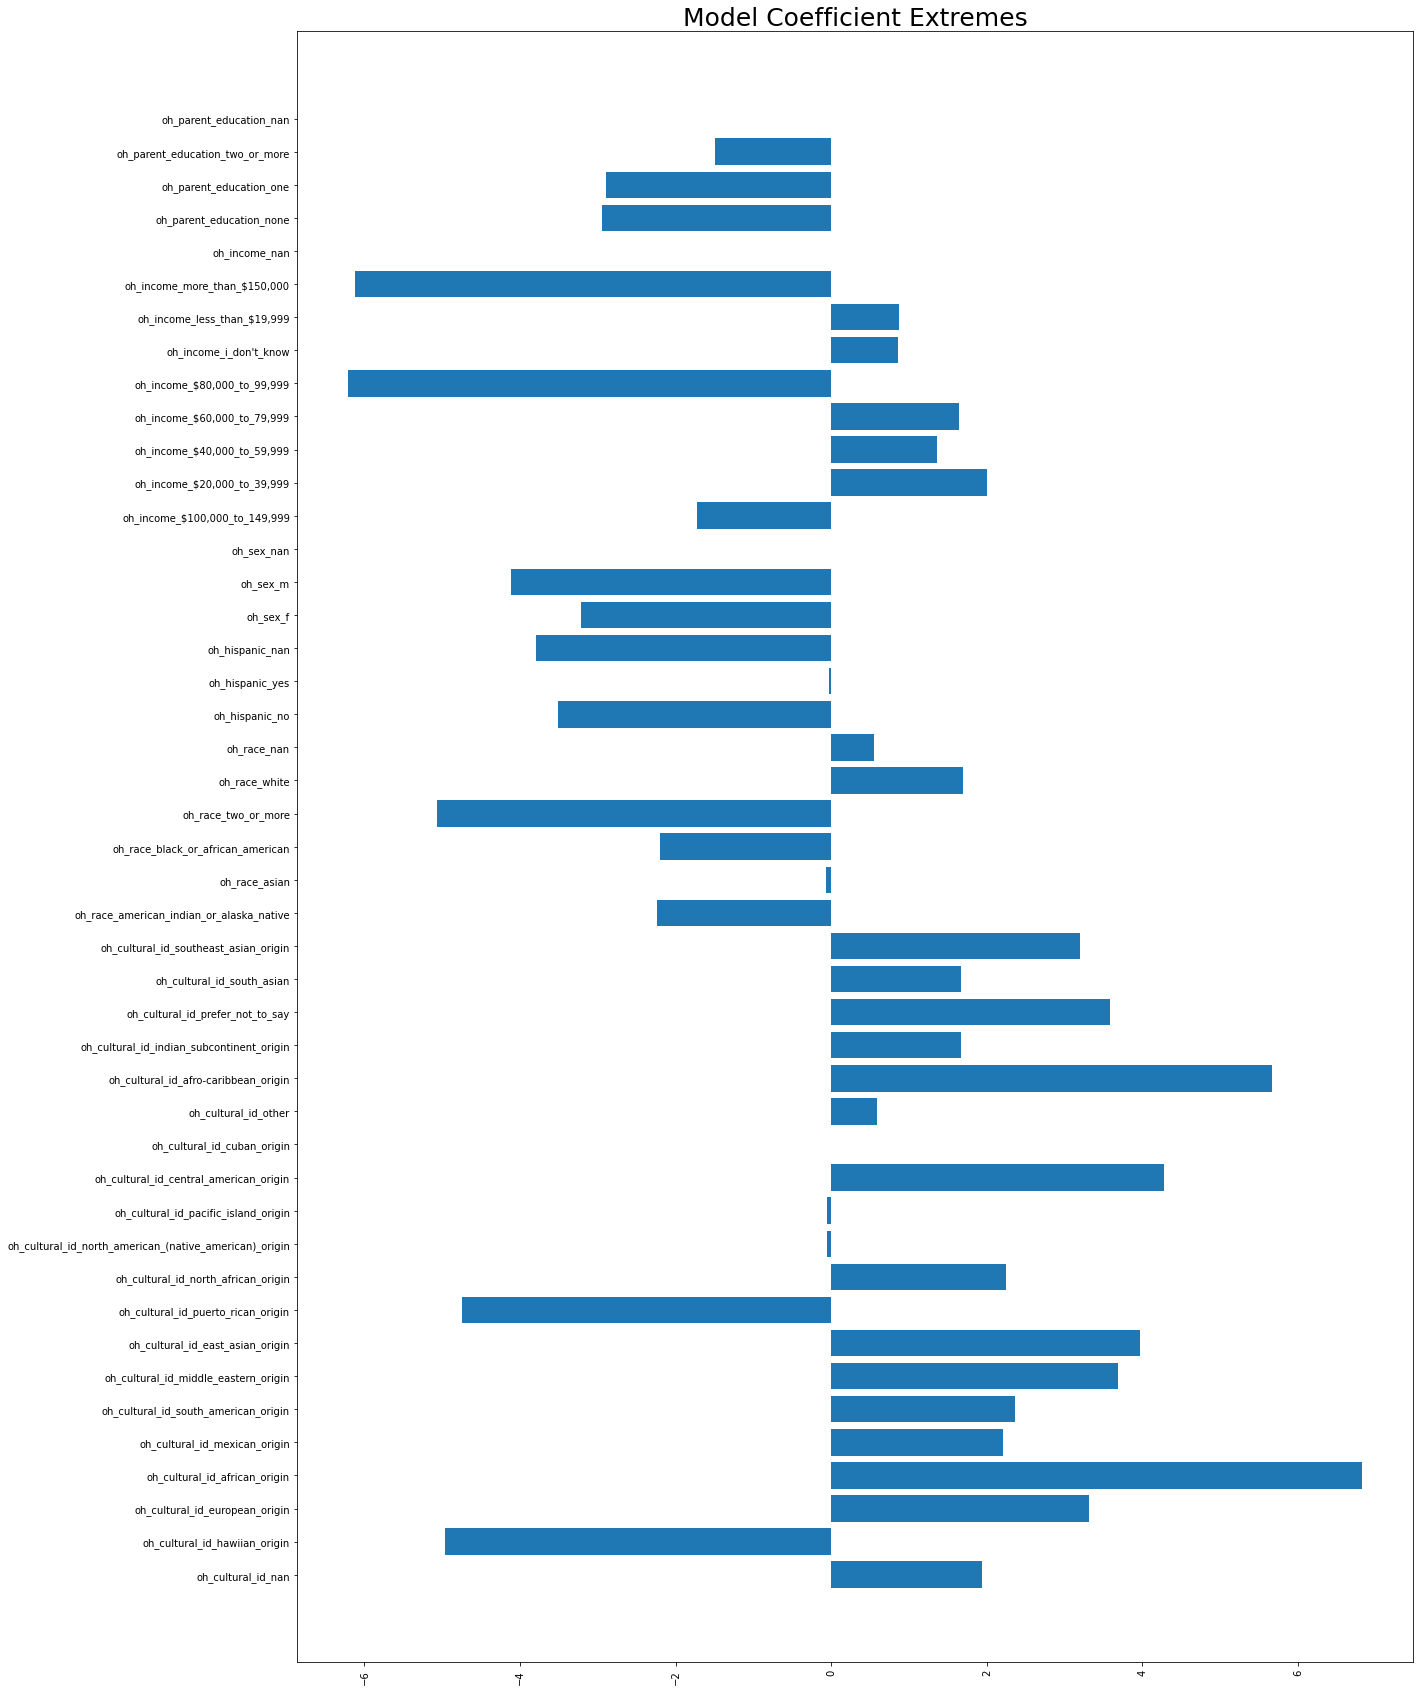

In [144]:
fig,ax = plt.subplots(1,figsize = (20,30))

ax.barh(coef_df_demo.column_names,coef_df_demo.coef_value)
plt.xticks(rotation = 90)
plt.title('Model Coefficient Extremes',fontsize = 25)

plt.show()

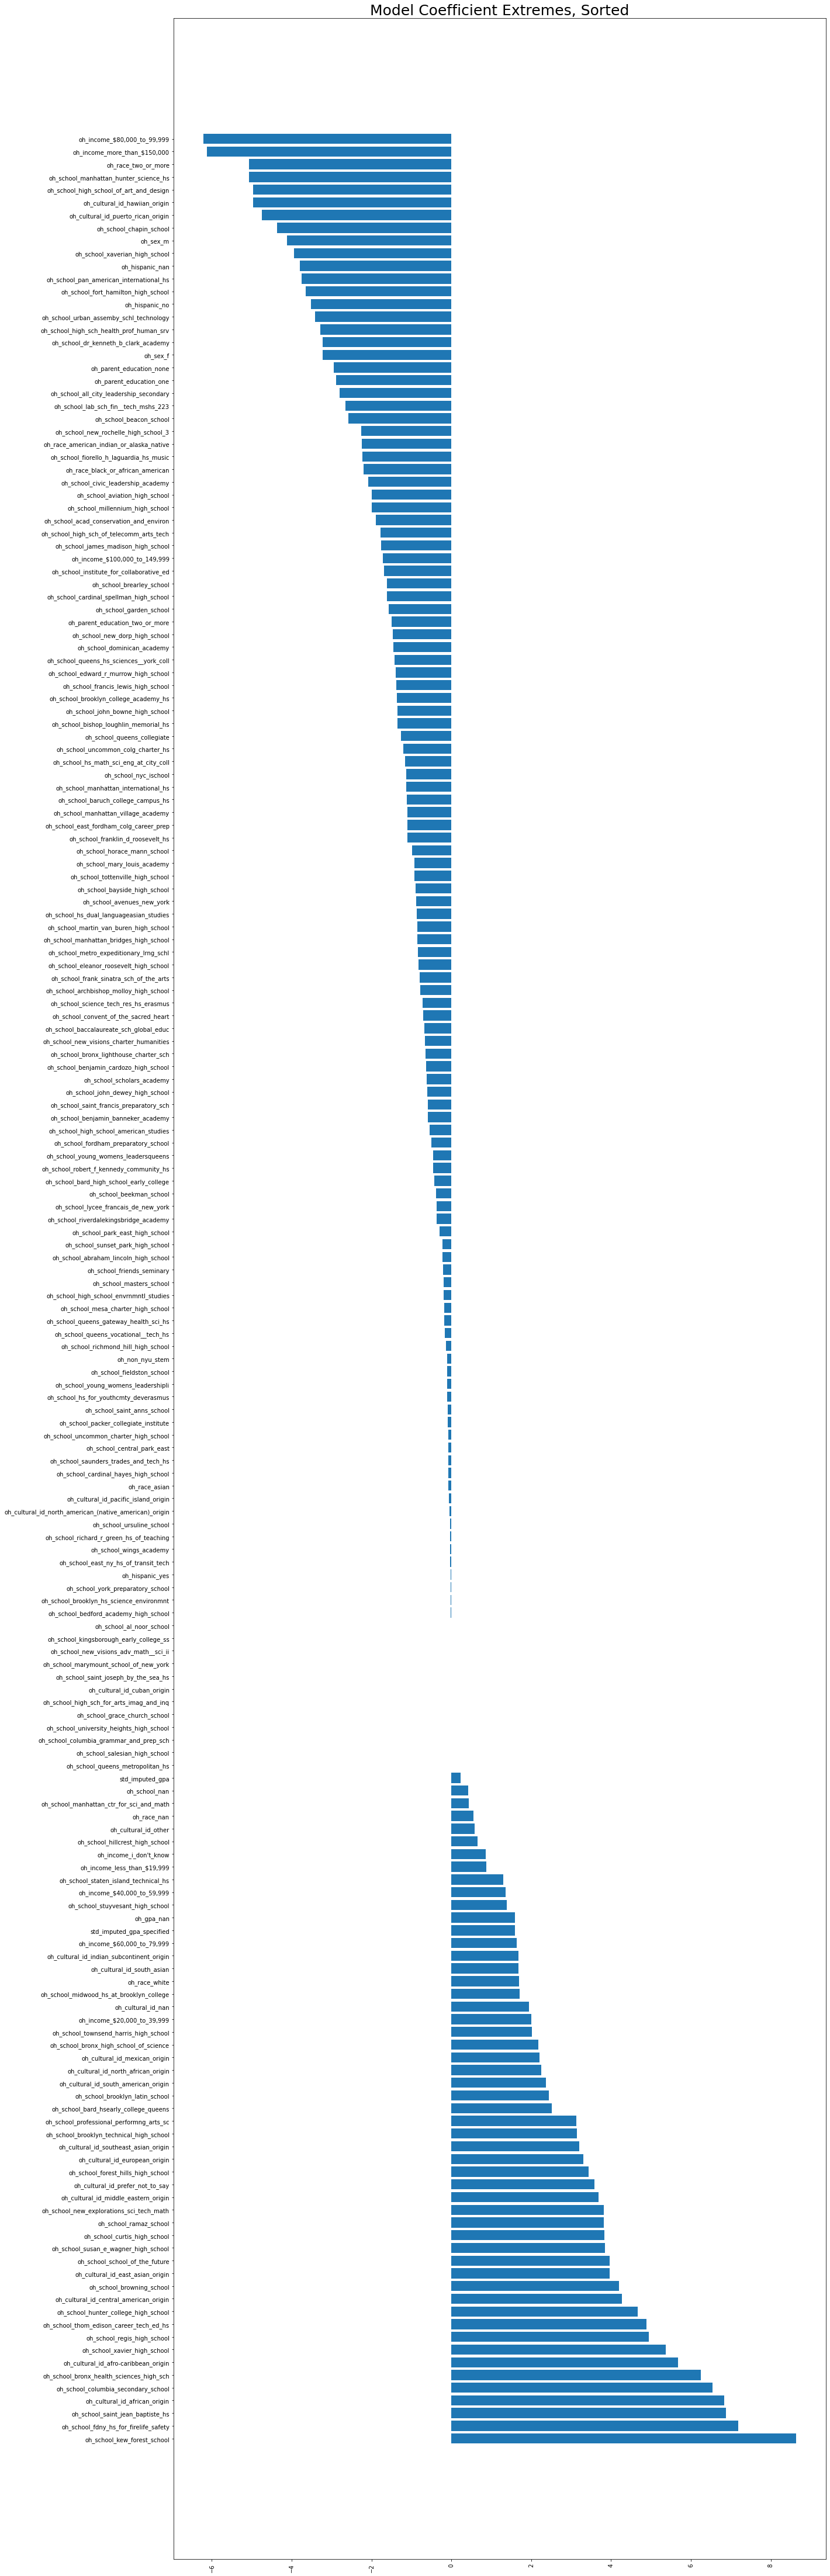

In [145]:
fig,ax = plt.subplots(1,figsize = (20,80))

ax.barh(coefs_df_filtered.column_names,coefs_df_filtered.coef_value)
plt.xticks(rotation = 90)
plt.title('Model Coefficient Extremes, Sorted',fontsize = 25)

plt.show()